# Series de Tiempo
Una serie de tiempo es una secuencia de datos, observaciones o valores, medidos en determinados instantes y ordenados cronológicamente. Una característica determinante es que los datos son registrados en intervalos regulares de tiempo, por ejemplo, horas, días, semanas, etc. La toma de muestras en puntos adyacentes en el tiempo introduce correlación, lo cual puede restringir la aplicación de métodos estadísticos que dependen del supuesto de que las observaciones son independientes y están distribuidas de forma idéntica.

Las tareas de predicción son quizás las más comunes en aplicaciones de Machine Learning del mundo real. El objeto principal de la predicción es la serie de tiempo, las cuales pueden ser utilizadas para representar datos en diversas áreas de aplicación, por ejemplo, en economía la tasa de cambio de una moneda, en meteorología la irradiancia de una zona, etc. La tarea de predicción en una serie de tiempo se realiza teniendo en cuenta los datos disponibles y posiblemente información de factores relacionados.

Primero vamos a configurar nuestro entorno de trabajo importando todas las librerias necesarias.

In [23]:
import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Para empezar vamos a observar unos ejemplos de como se ve una serie de tiempo. Vamos a cargar 3 series, la primera relacionada con la temperatura en Seattle, la segunda con el número de vehiculos que cruzan un tunel y la última con las manchas del sol. 

In [24]:
data=pd.read_csv('seattle_weather_1948-2017.csv')

data.set_index(
    pd.PeriodIndex(np.array(data.DATE), freq="D"),
    inplace=True,
)

data.drop("DATE", axis=1, inplace=True)
data.head()

tunnel = pd.read_csv('tunnel.csv')
tunnel.set_index(
    pd.PeriodIndex(np.array(tunnel.Day), freq="D"),
    inplace=True,
)

tunnel.drop("Day", axis=1, inplace=True)
tunnel.head()

sun = pd.read_csv('Sunspots.csv')
sun.set_index(
    pd.PeriodIndex(np.array(sun.Date), freq="M"),
    inplace=True,
)

sun.drop("Date", axis=1, inplace=True)
sun = sun.drop(sun.columns[[0]], axis=1)
sun.rename(columns = {'Monthly Mean Total Sunspot Number':'sunspot'}, inplace = True)
sun.head()

,sunspot
1749-01,96.7
1749-02,104.3
1749-03,116.7
1749-04,92.8
1749-05,141.7


Luego de cargar las tres series de tiempo de ejemplo podemos observar su comportamiento en el tiempo. 

La primera serie de tiempo muestra la temperatura máxima de Seattle en °F, esta serie es estacional. Decimos que una serie de tiempo presenta estacionalidad siempre que haya un cambio regular y periódico en la media de la serie. Los cambios estacionales suelen seguir el reloj y el calendario, por ejemplo, repeticiones a lo largo de un día, una semana o un año. La estacionalidad suele estar motivada por los ciclos del mundo natural a lo largo de los días y los años o por las convenciones del comportamiento social en torno a las fechas y las horas.

En el segundo ejemplo, donde se muestra el número de vehículos que pasan por un túnel con mediciones diarias, se puede observar una tendencia creciente. El componente de tendencia de una serie de tiempo representa un cambio persistente y a largo plazo en la media de la serie. La tendencia es la parte más lenta de una serie, la que representa la mayor escala temporal de importancia. En una serie temporal de ventas de productos, una tendencia creciente podría ser el efecto de una expansión del mercado a medida que más personas conocen el producto año tras año.

Para el tercer ejemplo podemos decir que algunas propiedades de las series de tiempo sólo pueden modelarse como propiedades dependientes de la serie, es decir, utilizando como características valores pasados de la serie objetivo.
Una forma especialmente común de manifestarse la dependencia serial es en los ciclos. Los ciclos son patrones de crecimiento y decadencia en una serie de tiempo asociados a la forma en que el valor de una serie en un momento dado depende de los valores en momentos anteriores, pero no necesariamente del propio paso de tiempo. El comportamiento cíclico es característico de los sistemas que pueden afectarse a sí mismos o cuyas reacciones persisten en el tiempo. Algunos ejemplos de series que muestran comportamiento cíclico son las economías, las epidemias, las poblaciones de animales, entre otros fenómenos naturales.

Lo que distingue los comportamientos cíclicos de la estacionalidad es que los ciclos no son necesariamente dependientes del tiempo, como la estacionalidad. Lo que pasa en un ciclo está menos relacionado con una fecha particular de ocurrencia, y más acerca de lo que ha pasado en el pasado reciente. La independencia (por lo menos relativa) del tiempo significa que los comportamientos cíclicos pueden ser mucho más irregulares que la estacionalidad.

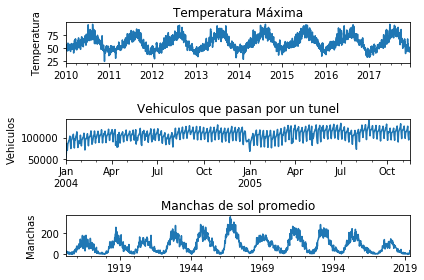

In [25]:
plt.subplot(311)
ax = data.TMAX["2010-01-01":"2017-12-14"].plot(title='Temperatura Máxima')
_ = ax.set(ylabel="Temperatura")

plt.subplot(312)
ax = tunnel.NumVehicles["2004-01-01":"2005-11-16"].plot(title='Vehiculos que pasan por un tunel')
_ = ax.set(ylabel="Vehiculos")

plt.subplot(313)
ax = sun.sunspot["1900-01":"2020-12"].plot(title='Manchas de sol promedio')
_ = ax.set(ylabel="Manchas")

plt.tight_layout()
plt.show()

En la primera parte de este tutorial, usaremos el algoritmo de regresión lineal para construir modelos de predicción. La regresión lineal es ampliamente usada en la práctica y se adapta naturalmente incluso a tareas complejas de predicción. Básicamente, el algoritmo aprende como hacer una suma ponderada de sus características de entrada. Por ejemplo, para dos características tenemos:
$$Target = weight_{1}*feature_{1} + weight_{2}*feature_{2} + bias$$
Durante el entrenamiento, el algoritmo de regresión aprende valores para los parámetros $weight_{1}$, $weight_{2}$, y bias que mejor ajustan el objetivo. Los pesos son llamados coeficientes de regresión y el bias es también llamado punto de corte, pues indica donde la gráfica de esta función cruza con el eje y.

## Series Retardadas y Gráficos de Retardo
Para investigar la posible dependencia serial (como ciclos) en una serie de tiempo, necesitamos crear copias retrasadas de la serie. Retrasar una serie de tiempo significa desplazar sus valores hacia delante uno o más pasos de tiempo. O equivalentemente, desplazar los tiempos de su índice hacia atrás uno o más pasos. En ambos casos el efecto es que las observaciones en la serie retrasada aparentarán haber ocurrido después en el tiempo.

Al retrasar una serie de tiempo, podemos hacer que sus valores pasados parezcan contemporáneos a los valores que intentamos predecir (en la misma fila, en otras palabras). Esto hace que las series retardadas sean útiles como características para modelar la dependencia serial. Para predecir la serie de la tasa de desempleo de EE.UU., podríamos utilizar $y_{lag_{1}}$ y $y_{lag_{2}}$ como características para predecir el objetivo $y$. Esto predeciría la tasa de desempleo futura en función de la tasa de desempleo de dos meses anteriores.

In [26]:
reserve = pd.read_csv(
    "desempleo.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


### Escogiendo los Retardos
Cuando eliges retardos para usar como características, generalmente no será útil incluir todos los lags con una autocorrelación grande. En US Unemployment, por ejemplo, la autocorrelación en el $lag_{2}$ podría ser el resultado de la información descompuesta del retardo 1 - sólo la correlación que se arrastra desde el paso anterior. Si el $lag_{2}$ no contiene nada nuevo, no habría razón para incluirlo si ya tenemos el $lag_{1}$.

La autocorrelación parcial nos indica la correlación de un retardo teniendo en cuenta todos los retardos anteriores, es decir, la cantidad de correlación "nueva" que aporta el retardo, por así decirlo. El trazado de la autocorrelación parcial puede ayudarnos a elegir las características de los retardos que debemos utilizar. En la figura siguiente, los retardos 1 a 6 caen fuera de los intervalos de "no correlación" (en azul), por lo que podríamos elegir estos retardos (1 a 6) como características para el conjunto de datos Desempleo en EE.UU. (El retardo 11 es probablemente un falso positivo).

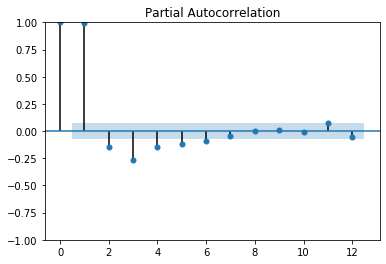

In [27]:
_ = plot_pacf(y, lags=12, method='ywm')

Debemos tener en cuenta que la autocorrelación y la autocorrelación parcial son medidas de dependencia lineal. Dado que las series temporales del mundo real suelen tener dependencias no lineales sustanciales, es mejor observar un gráfico de retardos (o utilizar alguna medida de dependencia más general, como la información mutua) al elegir las características de los rezagos. Por ejemplo, la serie de manchas solares tiene retardos con dependencia no lineal que podríamos pasar por alto con la autocorrelación.

## Regresión Lineal
Para la implementación del ejemplo se utilizará el conjunto de datos “Flu Trends” (Tendencias de la gripe), el cual contiene datos de visitas de doctores por gripe en periodos de semanas entre 2009 y 2016. El objetivo es predecir el número de visitas a medicos para las próximas semanas.
Se tomarán dos aproximaciones, para la primera se tendrán en cuenta las visitas a medicos usando retardos. Para la segunda aproximación además de tener en cuenta las visitas a medicos, se tomarán otras características relacionadas usando retardos. Específicamente, se tomarán términos de búsqueda relacionados con la gripe capturados con Google Trends.

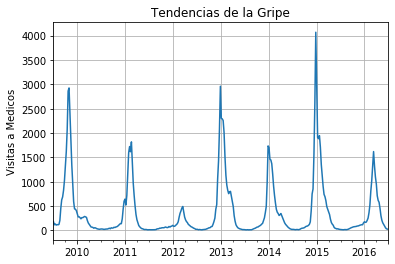

In [28]:
data = pd.read_csv('flu-trends.csv')

data.set_index(
    pd.PeriodIndex(np.array(data.Week), freq="W"),
    inplace=True,
)

data.drop("Week", axis=1, inplace=True)

ax = data.FluVisits.plot(title='Tendencias de la Gripe')
_ = ax.set(ylabel="Visitas a Medicos")
ax.grid(True)
plt.show()

La gráfica de la serie de tiempo muestra ciclos irregulares en vez de una estacionalidad regular: los picos tienden a ocurrir en año nuevo, pero algunas veces antes o después, algunas veces más grande o pequeño. Modelar estos ciclos con características retrasadas permitirá a nuestro predictor reaccionar dinámicamente a condiciones cambiantes en lugar de limitarse a fechas y horas exactas, como ocurre con las características estacionarias.

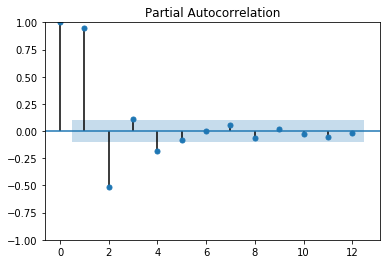

In [29]:
# autocorrelacion parcial
_ = plot_pacf(data.FluVisits, lags=12, method='ywm')
plt.show()

La gráfica de autocorrelación parcial sugiere que la dependencia puede ser captada usando los retardos 1, 2, 3 y 4. Podemos generar los retardos de la serie de tiempo usando el método shift de la librería Pandas. Primero definiremos una función útil para generar retardos en la serie de tiempo. Esta función toma como parámetros la serie y el número de retardos deseados y nos retorna la serie retardada. Como vimos anteriormente, al generar retardos en la serie de tiempo se agregan valores NaN (Not a Number), no es útil mantener estos valores. Para este problema, rellenaremos los valores faltantes que el retardo genera con 0.0. Se deben entender estos valores como el inicio de la serie, donde no tenemos mediciones disponibles.

In [30]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

#Generando lags en el objetivo
X = make_lags(data.FluVisits, lags=4)
X = X.fillna(0.0)
X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


Vamos a utilizar la serie de tiempo con los retardos generados. Primero debemos tener una salida, entiéndase como el objetivo de la predicción, que en este caso serán las visitas al médico. Debemos recordar que de esta misma característica generamos las características de retardo.

Posteriormente, tomamos las características de retardo y las salidas y hacemos la división en datos de entrenamiento y prueba. Es necesario que agreguemos el argumento shuffle en False, pues queremos que se tomen los valores hasta un índice determinado para entrenamiento y los siguientes para prueba, ya que es importante mantener el índice de tiempo.

In [31]:
y = data.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

Para este ejercicio utilizaremos el modelo de Regresión Lineal. Primero definimos el modelo y posteriormente lo ajustamos utilizando los datos de entrenamiento, tanto las características como la salida.

Una vez el modelo está ajustado, podemos hacer las predicciones, primero con los datos de entrenamiento y posteriormente con los datos de prueba. Es importante seguir manteniendo el índice de tiempo, por lo cual indicamos que queremos que las predicciones se guarden como serie y que además mantengan el índice de los datos originales.

In [32]:
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

Ahora observemos la gráfica de la serie de tiempo, en color rojo se muestran las predicciones realizadas con los datos de prueba. A primera vista las predicciones presentan un buen ajuste a los datos de entrenamiento y de prueba.

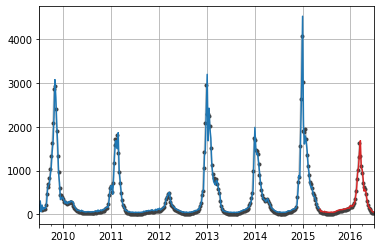

In [33]:
ax = y_train.plot(color="0.75",style=".-",markeredgecolor="0.25",markerfacecolor="0.25")
ax = y_test.plot(color="0.75",style=".-",markeredgecolor="0.25",markerfacecolor="0.25")
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')
ax.grid(True)
plt.show()

Sin embargo, cuando se utilizan características retrasadas, estamos limitados a realizar predicciones donde se tengan disponibles sus valores retrasados. Por ejemplo, usando 1 característica de retardo en lunes, no podemos hacer una predicción para el miércoles, porque el retardo de un paso necesita de la información del martes, lo que aún no ha ocurrido.

Si observamos sólo los valores de la predicción, podemos ver cómo nuestro modelo necesita un paso de tiempo para reaccionar a los cambios repentinos de la serie objetivo. Esta es una limitación habitual de los modelos que sólo utilizan rezagos de la serie objetivo como características.

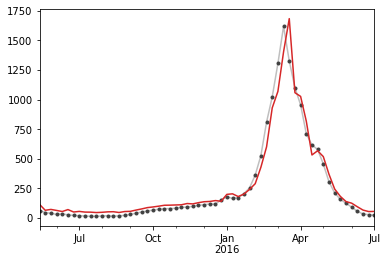

In [34]:
# Graficando solo las predicciones
ax = y_test.plot(color="0.75",style=".-",markeredgecolor="0.25",markerfacecolor="0.25")
_ = y_fore.plot(ax=ax, color='C3')
plt.show()

Para mejorar la predicción, podemos intentar encontrar indicadores principales, una serie de tiempo que puede proporcionar una “alerta temprana” para los cambios en la tendencia de la gripe.

Graficando la palabra de búsqueda “tos” y comparándola con el objetivo, se puede observar como tales términos pueden ser usados como indicadores principales. Búsquedas relacionadas con la gripe suelen ser más populares en las semanas anteriores a las visitas oficiales.

El conjunto de datos contiene 129 términos de búsqueda relacionados. Sin embargo, para este ejercicio solo usaremos algunos de ellos.

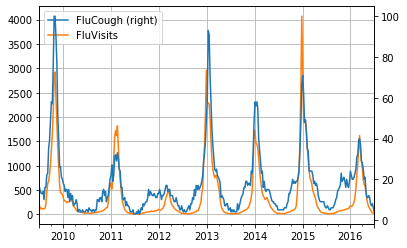

In [35]:
ax = data.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)
ax.grid(True)
plt.show()

search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA",
                "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

Vamos a generar un nuevo conjunto de datos, en este caso primero usaremos los términos de búsquedas relacionadas. Debemos generar retardos, pero teniendo claro que la idea es generar una alerta temprana, así que usaremos 3 retardos.

Para la característica principal utilizaremos los 4 retardos que anteriormente utilizamos.

In [36]:
# Creamos 3 retardos para cada busqueda relacionada
X0 = make_lags(data[search_terms], lags=3)

# Creamos cuatro retardos para el objetivo
X1 = make_lags(data['FluVisits'], lags=4)

En el siguiente segmento de código realizamos varias tareas:

-Generamos el nuevo conjunto de datos concatenando los retardos generados anteriormente.

-Realizamos nuevamente la división en un conjunto para entrenamiento y otro para pruebas.

-Definimos y ajustamos el modelo a utilizar.

-Finalmente realizamos las predicciones con el modelo ajustado y los datos de entrenamiento y prueba.

In [37]:
X = pd.concat([X0, X1], axis=1).fillna(0.0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

Al observar la gráfica de las predicciones, aparentemente nuestra predicción es más irregular, sin embargo, nuestro modelo tiene la capacidad de anticipar aumentos repentinos en las visitas por gripe. Sugiriendo que las series de tiempo de búsquedas populares fueron identificadas efectivamente como indicadores principales.

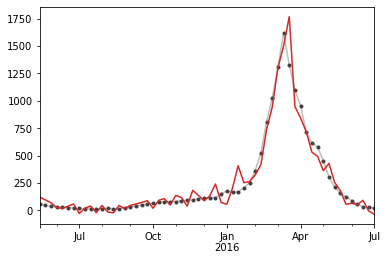

In [38]:
ax = y_test.plot(color="0.75",style=".-",markeredgecolor="0.25",markerfacecolor="0.25")
_ = y_fore.plot(ax=ax, color='C3')
plt.show()

## Conclusiones
En este tutorial aprendimos el concepto básico de las series de tiempo, pudimos observar que esta forma de representar datos es importante en diversas áreas del conocimiento. Tuvimos nuestro primer acercamiento con el modelado de una serie mediante retardos, vimos como con un algoritmo sencillo como el de regresión lineal, podemos ejecutar predicciones bastante acertadas de nuestra serie de tiempo. Sin embargo, al utilizar solo los retardos de la serie, se genera un efecto de delay en la respuesta. Para intentar dar solución a este problema, se agregaron características relacionadas, utilizadas como método de alerta temprana. Con esta estrategia se resolvió el problema del delay, sin embargo, la predicción de nuestro modelo se ve un poco más irregular que el obtenido en el entrenamiento con la variable original y los retardos.